Plot rat position overlayed on the hex maze

In [2]:
import datajoint as dj
from pynwb import NWBHDF5IO, NWBFile
import spyglass.common as sgc
from spyglass.common import Nwbfile, Session, TaskEpoch, IntervalList
from hex_maze_behavior import populate_all_hexmaze, HexMazeConfig, HexCentroids, HexMazeBlock

dj.config['shared_modules'] = ['hex_maze']
schema = dj.schema('hex_maze')

nwb_file_name = "Toby20250316_.nwb"
key = {"nwb_file_name": nwb_file_name}

# one line <3
#populate_all_hexmaze(nwb_file_name)

In [2]:
# Show the HexMazeBlock table
print("HexMazeBlock table:")
display(HexMazeBlock() & key)

# Show the Trial part table
print("HexMazeBlock().Trial part table:")
display(HexMazeBlock().Trial() & key)

# Show the HexMazeConfig table
print("HexMazeConfig table:")
display(HexMazeConfig() & key)

# Show the HexCentroids table
print("HexCentroids table:")
display(HexCentroids() & key)

print("HexCentroidsPart")
display((HexCentroids().HexCentroidsPart()) & key)

HexMazeBlock table:


nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),block the block number within the epoch,config_id maze configuration as a string,p_a probability of reward at port A,p_b probability of reward at port B,p_c probability of reward at port C,num_trials number of trials in this block,"block_interval [start_time, end_time] defining block bounds",task_type 'barrier shift' or 'probabilty shift'
Toby20250316_.nwb,1,1,"10,12,18,21,25,28,34,37,42,45",50.0,90.0,10.0,69,=BLOB=,probability change
Toby20250316_.nwb,1,2,"10,12,18,21,25,28,34,37,42,45",50.0,10.0,90.0,69,=BLOB=,probability change
Toby20250316_.nwb,1,3,"10,12,18,21,25,28,34,37,42,45",90.0,50.0,10.0,69,=BLOB=,probability change
Toby20250316_.nwb,3,1,"8,9,11,17,20,23,31,34,38,46",10.0,50.0,90.0,52,=BLOB=,barrier change
Toby20250316_.nwb,3,2,"8,9,11,20,23,30,31,34,38,46",10.0,50.0,90.0,70,=BLOB=,barrier change
Toby20250316_.nwb,3,3,"8,9,11,16,23,30,31,34,38,46",10.0,50.0,90.0,44,=BLOB=,barrier change
Toby20250316_.nwb,3,4,"8,9,11,16,26,30,31,34,38,46",10.0,50.0,90.0,40,=BLOB=,barrier change
Toby20250316_.nwb,3,5,"8,9,11,16,24,26,31,34,38,46",10.0,50.0,90.0,10,=BLOB=,barrier change
Toby20250316_.nwb,5,1,"7,10,19,21,22,24,35,42,43,46",90.0,10.0,50.0,69,=BLOB=,probability change
Toby20250316_.nwb,5,2,"7,10,19,21,22,24,35,42,43,46",50.0,90.0,10.0,69,=BLOB=,probability change


HexMazeBlock().Trial part table:


nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),block the block number within the epoch,block_trial_num trial number within the block,epoch_trial_num trial number within the epoch,reward if the rat got a reward,"start_port A, B, or C","end_port A, B, or C","opto_cond description of opto condition, if any (delay / no_delay)","trial_interval [start_time, end_time] defining trial bounds","poke_interval np.array of [poke_in, poke_out]",duration trial duration in seconds
Toby20250316_.nwb,1,1,1,1,1,None,B,None,=BLOB=,=BLOB=,8.80213
Toby20250316_.nwb,1,1,2,2,0,B,A,None,=BLOB=,=BLOB=,56.077
Toby20250316_.nwb,1,1,3,3,0,A,C,None,=BLOB=,=BLOB=,14.7417
Toby20250316_.nwb,1,1,4,4,1,C,B,None,=BLOB=,=BLOB=,30.2608
Toby20250316_.nwb,1,1,5,5,1,B,A,None,=BLOB=,=BLOB=,67.6388
Toby20250316_.nwb,1,1,6,6,0,A,C,None,=BLOB=,=BLOB=,9.96265
Toby20250316_.nwb,1,1,7,7,0,C,A,None,=BLOB=,=BLOB=,12.5009
Toby20250316_.nwb,1,1,8,8,1,A,B,None,=BLOB=,=BLOB=,19.3462
Toby20250316_.nwb,1,1,9,9,0,B,A,None,=BLOB=,=BLOB=,13.4592
Toby20250316_.nwb,1,1,10,10,0,A,C,None,=BLOB=,=BLOB=,26.5478


HexMazeConfig table:


config_id maze configuration as a string,len_ab number of hexes on optimal path between ports A and B,len_bc number of hexes on optimal path between ports B and C,len_ac number of hexes on optimal path between ports A and C,"path_length_diff max path length difference between lenAB, lenBC, lenAC",num_choice_points number of critical choice points for this maze config,num_cycles number of graph cycles (closed loops) for this maze config,choice_points list of hexes that are choice points (not query-able),num_dead_ends number of dead ends at least 3 hexes long,optimal_pct percentage of maze hexes that are on optimal paths,non_optimal_pct percentage of maze hexes that are on non-optimal paths,dead_end_pct percentage of maze hexes that are on dead-end paths
"10,12,18,21,25,28,34,37,42,45",23,17,19,6,1,0,=BLOB=,1,74.36,0.0,25.64
"10,14,18,19,20,23,30,42,43,46",17,17,23,6,3,2,=BLOB=,1,82.05,0.0,17.95
"10,14,18,20,23,26,29,42,43,46",19,17,21,4,3,1,=BLOB=,2,76.92,0.0,23.08
"10,14,18,20,23,26,30,42,43,46",21,17,15,6,3,1,=BLOB=,2,71.79,0.0,28.21
"10,16,18,19,20,23,30,42,43,46",15,17,21,6,3,2,=BLOB=,1,76.92,0.0,23.08
"10,16,18,19,23,30,31,42,43,46",15,17,17,2,1,1,=BLOB=,2,61.54,10.26,28.21
"11,12,14,15,18,20,22,29,31,45",17,15,17,2,1,3,=BLOB=,1,66.67,15.38,17.95
"11,12,14,15,18,22,29,31,35,45",17,17,15,2,3,4,=BLOB=,0,71.79,15.38,12.82
"11,12,14,15,20,29,31,36,45",15,17,17,2,1,3,=BLOB=,1,65.0,15.0,20.0
"5,14,16,17,23,30,32,37,39,45",23,19,17,6,1,0,=BLOB=,1,74.36,0.0,25.64


HexCentroids table:


nwb_file_name name of the NWB file
Toby20250316_.nwb


HexCentroidsPart


nwb_file_name name of the NWB file,hex the hex ID in the hex maze (1-49),"x_pixels the x coordinate of the hex centroid, in video pixel coordinates","y_pixels the y coordinate of the hex centroid, in video pixel coordinates","x_cm the x coordinate of the hex centroid, in cm","y_cm the y coordinate of the hex centroid, in cm"
Toby20250316_.nwb,1,1072.0,881.0,171.52,140.96
Toby20250316_.nwb,10,872.0,766.0,139.52,122.56
Toby20250316_.nwb,11,949.0,649.0,151.84,103.84
Toby20250316_.nwb,12,733.0,842.0,117.28,134.72
Toby20250316_.nwb,13,804.0,725.0,128.64,116.0
Toby20250316_.nwb,14,879.0,605.0,140.64,96.8
Toby20250316_.nwb,15,666.0,875.0,106.56,140.0
Toby20250316_.nwb,16,733.0,764.0,117.28,122.24
Toby20250316_.nwb,17,807.0,646.0,129.12,103.36
Toby20250316_.nwb,18,880.0,525.0,140.8,84.0


In [8]:
from hex_maze_behavior import HexPositionSelection

all_valid_keys = HexPositionSelection.get_valid_keys()
for key in all_valid_keys:
    if key['nwb_file_name'] == nwb_file_name:
        print(key)

Skipping {'nwb_file_name': 'BraveLu20240622_.nwb', 'interval_list_name': 'pos 1 valid times'}. Check that this session has data in the PositionOutput table
Skipping {'nwb_file_name': 'BraveLu20240622_.nwb', 'interval_list_name': 'pos 3 valid times'}. Check that this session has data in the PositionOutput table
Skipping {'nwb_file_name': 'BraveLu20240622_.nwb', 'interval_list_name': 'pos 5 valid times'}. Check that this session has data in the PositionOutput table
{'nwb_file_name': 'Toby20250316_.nwb', 'epoch': 1, 'block': 1, 'merge_id': UUID('4eeb7432-969b-f856-3cfb-dd4456754ac4')}
{'nwb_file_name': 'Toby20250316_.nwb', 'epoch': 1, 'block': 1, 'merge_id': UUID('713b3445-c1da-79f1-4b8e-c5760e604d20')}
{'nwb_file_name': 'Toby20250316_.nwb', 'epoch': 1, 'block': 2, 'merge_id': UUID('4eeb7432-969b-f856-3cfb-dd4456754ac4')}
{'nwb_file_name': 'Toby20250316_.nwb', 'epoch': 1, 'block': 2, 'merge_id': UUID('713b3445-c1da-79f1-4b8e-c5760e604d20')}
{'nwb_file_name': 'Toby20250316_.nwb', 'epoch': 

In [26]:
# Grab a merge id from the output above for now
# Use this merge id to restrict the PositionOutput table and fetch the position data
key = {'nwb_file_name': 'Toby20250316_.nwb', 'epoch': 3, 'block': 2, 'merge_id': '0859decd-5062-ee9c-a51f-575538d091f1'}
position_info = (PositionOutput & key).fetch1_dataframe()
display(position_info)

# Get maze config from block data
maze = (HexMazeBlock() & key).fetch1('config_id')
print(maze)

# Get reward probs
reward_probs = list((HexMazeBlock() & key).fetch1("p_a", "p_b", "p_c"))
print(reward_probs)

# Get the hex centroids
centroids_dict = HexCentroids().get_hex_centroids_dict_cm(key)
# Remove side hex centroids
centroids_dict = {int(k): v for k, v in centroids_dict.items() if "_left" not in k and "_right" not in k}
print(centroids_dict)

,video_frame_ind,position_x,position_y,orientation,velocity_x,velocity_y,speed
time,,,,,,,
1.742158e+09,0,NaN,NaN,NaN,NaN,NaN,NaN
1.742158e+09,1,NaN,NaN,NaN,NaN,NaN,NaN
1.742158e+09,2,NaN,NaN,NaN,NaN,NaN,NaN
1.742158e+09,3,NaN,NaN,NaN,NaN,NaN,NaN
1.742158e+09,4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1.742161e+09,90497,122.66,100.92,0.131112,45.751447,-1.235029,45.768114
1.742161e+09,90498,124.48,100.70,0.146666,41.854471,-1.409508,41.878197
1.742161e+09,90499,125.94,100.54,0.170735,36.808128,-1.244142,36.829148


8,9,11,20,23,30,31,34,38,46
[10.0, 50.0, 90.0]
{1: (171.52, 140.96), 10: (139.52, 122.56), 11: (151.84, 103.84), 12: (117.28, 134.72), 13: (128.64, 116.0), 14: (140.64, 96.8), 15: (106.56, 140.0), 16: (117.28, 122.24), 17: (129.12, 103.36), 18: (140.8, 84.0), 19: (95.84, 133.76), 2: (106.4, 24.96), 20: (106.4, 115.68), 21: (117.92, 96.32), 22: (129.12, 77.28), 23: (85.44, 138.88), 24: (95.68, 121.6), 25: (106.08, 103.2), 26: (117.92, 83.36), 27: (129.6, 63.84), 28: (75.36, 132.32), 29: (85.12, 114.88), 3: (46.56, 136.32), 30: (95.2, 96.0), 31: (106.72, 76.64), 32: (118.4, 57.12), 33: (65.76, 137.44), 34: (74.72, 120.48), 35: (84.48, 102.24), 36: (95.2, 83.2), 37: (106.56, 63.84), 38: (118.08, 44.16), 39: (64.48, 113.76), 4: (160.96, 134.88), 40: (74.08, 95.84), 41: (84.32, 76.64), 42: (95.68, 57.28), 43: (55.04, 119.36), 44: (63.84, 101.76), 45: (73.76, 83.2), 46: (84.32, 63.84), 47: (95.84, 44.32), 48: (55.84, 130.88), 49: (106.88, 37.6), 5: (149.92, 140.64), 6: (162.08, 122.72), 7: (

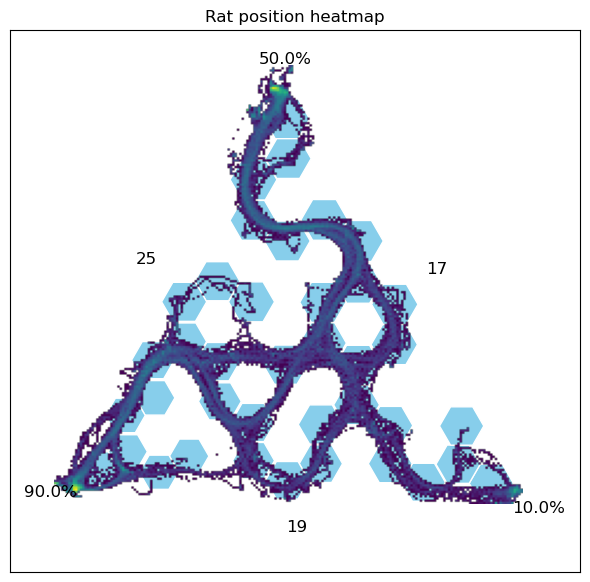

In [39]:
from hexmaze import plot_hex_maze

# TODO: once interval lists are good, filter properly to the block!
# # Filter position data for this block (exluding nans)
# block_times = (position_df["timestamp"] >= block.start_time) & (position_df["timestamp"] <= block.stop_time)
# block_positions = position_df[block_times].dropna(subset=['x', 'y'])
block_positions = position_info.dropna(subset=['position_x', 'position_y'])

# Plot rat position heatmap for this block (currently for session)
fig_full, ax_full = plt.subplots(figsize=(6, 6))

# Create 2D histogram (aka heatmap) of the rat's x, y positions in this block
heatmap_full, xedges, yedges = np.histogram2d(
    block_positions['position_x'].values, block_positions['position_y'].values, bins=200
)
heatmap_full_masked = np.ma.masked_where(heatmap_full == 0, heatmap_full)
log_heatmap_full = np.log1p(heatmap_full_masked)

# Plot maze layout (open hexes only) using custom centroids if they exist
if centroids_dict is not None:
    plot_hex_maze(
        barriers=maze, centroids=centroids_dict, ax=ax_full, show_hex_labels=False,
        show_barriers=False, show_choice_points=False, reward_probabilities=reward_probs,
        invert_yaxis=True
    )
# Plot rat position heatmap on top of the hexes
ax_full.imshow(
    log_heatmap_full.T, origin='lower', cmap='viridis',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    aspect='equal', zorder=1
)
ax_full.set_xticks([])
ax_full.set_yticks([])
ax_full.set_title(f"Rat position heatmap")
fig_full.tight_layout()
fig_full.show()